## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [1]:
import os
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

In [15]:
class params(object):
  def __init__(self):
    self.model_type = "mlp"
    self.model_name = "mlp_lca_recon_mnist"
    self.version = "0.0"
    self.save_info = "analysis"
    self.overwrite_analysis_log = False

analysis_params = params()
# Computed params
analysis_params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+analysis_params.model_name)

In [16]:
analyzer = ap.get_analyzer(analysis_params.model_type)
analyzer.setup(analysis_params)
analyzer.model.setup(analyzer.model_params)
analyzer.load_analysis(save_info=analysis_params.save_info)

In [19]:
analyzer.model_params.__dict__

{'batch_norm': [None, None, None, None],
 'batch_size': 100,
 'center_data': False,
 'contrast_normalize': False,
 'conv_strides': [[1, 1, 1, 1], [1, 1, 1, 1], None, None],
 'cp_int': 10000,
 'cp_latest_filename': 'latest_checkpoint_v0.0',
 'cp_load': True,
 'cp_load_dir': '/home/dpaiton/Work/Projects/lca_mnist/checkpoints/',
 'cp_load_latest_filename': 'latest_checkpoint_v0.0',
 'cp_load_name': 'lca_mnist',
 'cp_load_step': None,
 'cp_load_var': ['weights/w:0'],
 'cp_load_ver': '0.0',
 'cp_save_dir': '/home/dpaiton/Work/Projects/mlp_lca_recon_mnist/analysis/0.0//checkpoints/',
 'data_dir': '/home/dpaiton/Work/Datasets//MNIST/',
 'data_shape': [784],
 'data_type': 'mnist',
 'device': '/gpu:0',
 'disp_dir': '/home/dpaiton/Work/Projects/mlp_lca_recon_mnist/analysis/0.0//vis/',
 'dropout': [1.0, 1.0, 0.4, 1.0],
 'dt': 0.001,
 'eps': 1e-12,
 'extract_patches': False,
 'full_data_shape': [28, 28, 1],
 'gen_plot_int': 10000,
 'layer_types': ['conv', 'conv', 'fc', 'fc'],
 'log_dir': '/home/dp

In [6]:
# load data
data = ds.get_data(analyzer.model_params)
data = analyzer.model.preprocess_dataset(data, analyzer.model_params)
data = analyzer.model.reshape_dataset(data, analyzer.model_params)
data_min = data["test"].images.min()
data_max = data["test"].images.max()
print('DATA MIN', data_min, 'DATA MAX', data_max)

DATA MIN -39.181564 DATA MAX 42.101353


In [ ]:
print(type(analyzer.adversarial_input_image)) # input image used
print(type(analyzer.adversarial_target_class)) # target class used (0 through 9)
print(type(analyzer.adversarial_images)) # stim images used each step
print(type(analyzer.adversarial_outputs)) # adv confidence
print(type(analyzer.analysis_params.adversarial_step_size))
print(type(analyzer.analysis_params.adversarial_num_steps))
print(type(analyzer.analysis_params.adversarial_input_id))
print(type(analyzer.adversarial_input_adv_mses)) # MSEs for adv stims to input image
print(type(analyzer.adversarial_target_output_losses))

Text(0.5,1,'target')

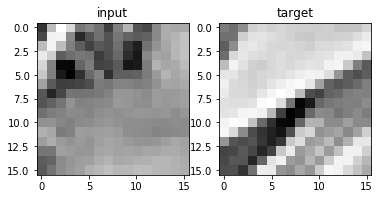

In [7]:
input_id = 1
target_id = 5
input_image = vh_data[input_id,...][None,...].astype(np.float32)
target_image = vh_data[target_id,...][None,...].astype(np.float32)
fig, axes = plt.subplots(1,2)
axes[0].imshow(np.squeeze(input_image).reshape(int(np.sqrt(analyzer.model_params.num_pixels)), int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys_r")
axes[0].set_title("input")
axes[1].imshow(np.squeeze(target_image).reshape(int(np.sqrt(analyzer.model_params.num_pixels)), int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys_r")
axes[1].set_title("target")
# plt.show()
# fig.savefig(analyzer.analysis_out_dir+"/vis/adversarial_input_target.png")

In [9]:
# NOTE: running this cell multiple times will cause it to create multiple copies of all of the graph variables.
# if changes are made here, just restart the notebook and run from scratch

shape = input_image.shape
learning_rate = 1e-3
with tf.device(analyzer.model.device): 
    with analyzer.model.graph.as_default(): 
        with tf.name_scope("carlini_vars") as scope:
            const = tf.placeholder(tf.float32, (), name='const_ph')
            modifier = tf.Variable(tf.random_normal(shape, mean=0.0, stddev=0.1), dtype=tf.float32, name='modifier')
            
            input_ph = tf.placeholder(tf.float32, shape, name='input_ph')
            target_ph = tf.placeholder(tf.float32, shape, name='target_ph')
            perturbed_input = tf.clip_by_value(input_ph + modifier, data_min, data_max)

            input_recon = analyzer.model.forward_pass(perturbed_input)
            target_recon = analyzer.model.forward_pass(target_ph)
        
            # MAKE UNPERTURBED LATENT STATE == PERTURBED LATENT STATE
#             target_latent = analyzer.model.compute_latent(input_ph)
#             input_latent = analyzer.model.compute_latent(perturbed_input)

            # losses
            l2_dist =  tf.reduce_sum(tf.square(input_ph - perturbed_input), [1]) # PERTURB LOSS
            loss1 = tf.reduce_sum(tf.square(target_recon - input_recon), [1]) # RECON LOSS
#             loss1 = tf.reduce_sum(tf.square(input_latent - target_latent), [1]) # LATENT LOSS

            loss = const*loss1 + l2_dist
            optimizer = tf.train.AdamOptimizer(learning_rate) 
            train = optimizer.minimize(loss, var_list=[modifier]) 


In [10]:
with analyzer.model.graph.as_default(): 
    var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='carlini_vars')
    print(var_list)

[<tf.Variable 'carlini_vars/modifier:0' shape=(1, 256) dtype=float32_ref>, <tf.Variable 'carlini_vars/beta1_power:0' shape=() dtype=float32_ref>, <tf.Variable 'carlini_vars/beta2_power:0' shape=() dtype=float32_ref>, <tf.Variable 'carlini_vars/modifier/Adam:0' shape=(1, 256) dtype=float32_ref>, <tf.Variable 'carlini_vars/modifier/Adam_1:0' shape=(1, 256) dtype=float32_ref>]


INFO:tensorflow:Restoring parameters from /home/jazzie/results/new_pretrained/sigmoid_autoencoder_reboot/checkpoints/sigmoid_autoencoder_reboot_v0.0_weights-700000
FINAL PERTURB SIZE 2320.52
FINAL AE LOSS 142.89851


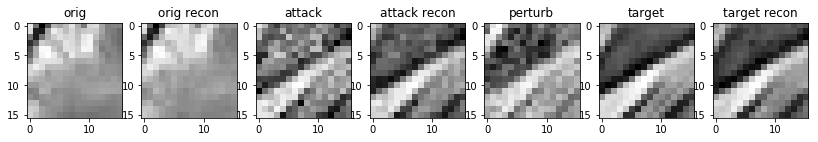

In [18]:
const_val = 5.0 # larger const --> put more weight on recon loss
num_steps = 10000
losses = []
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

mse = lambda x,y: np.mean(np.square(x - y))
losses = []
adversarial_images = []
recons = []
input_recon_mses = []
input_adv_mses = []
target_recon_mses = []
target_adv_mses = []
adv_recon_mses = []
input_target_mse = mse(input_image, target_image)
ae_loss = []
perturb_loss = []
total_loss = []

with analyzer.model.graph.as_default(): 
    vars_to_init = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='carlini_vars')

with tf.Session(config=config, graph=analyzer.model.graph) as sess:
    feed_dict = analyzer.model.get_feed_dict(input_image)
    sess.run(analyzer.model.init_op, feed_dict)
    sess.run(tf.initialize_variables(vars_to_init))
    analyzer.model.load_weights(sess, analyzer.cp_loc)
    orig = tf.constant(input_image, dtype=tf.float32, name="original_image")
    target = tf.constant(target_image, dtype=tf.float32, name="target_image")
    
    new_feed_dict = analyzer.model.get_feed_dict(input_image)
    new_feed_dict[input_ph] = input_image
    new_feed_dict[target_ph] = target_image
    new_feed_dict[const] = const_val

    orig_recon = sess.run(input_recon, feed_dict=new_feed_dict)
    
    for step in range(num_steps):
        _, ls1, ls2, full_l, new_img, perturb, recon, t_recon = sess.run([train, loss1, l2_dist, loss, perturbed_input, modifier, input_recon, target_recon], new_feed_dict)
        ae_loss.append(ls1)
        perturb_loss.append(ls2)
        total_loss.append(full_l)
        input_recon_mses.append(mse(input_image, recon))
        input_adv_mses.append(mse(input_image, new_img))
        target_recon_mses.append(mse(target_image, recon))
        target_adv_mses.append(mse(target_image, new_img))
        adv_recon_mses.append(mse(new_img, recon))
        recons.append(recon)

print('FINAL PERTURB SIZE', np.sum(np.square(perturb)))
print('FINAL AE LOSS', ls1[0])
fig, axes = plt.subplots(1,7, figsize=(14, 6))
axes[0].imshow(input_image.reshape(int(np.sqrt(analyzer.model_params.num_pixels)),int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys") # Greys_r
axes[0].set_title("orig")
axes[1].imshow(orig_recon.reshape(int(np.sqrt(analyzer.model_params.num_pixels)),int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys") # Greys_r
axes[1].set_title("orig recon")
axes[2].imshow(new_img.reshape(int(np.sqrt(analyzer.model_params.num_pixels)),int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys")
axes[2].set_title("attack")
axes[3].imshow(recon.reshape(int(np.sqrt(analyzer.model_params.num_pixels)),int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys")
axes[3].set_title("attack recon")
axes[4].imshow(perturb.reshape(int(np.sqrt(analyzer.model_params.num_pixels)),int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys")
axes[4].set_title("perturb")
axes[5].imshow(target_image.reshape(int(np.sqrt(analyzer.model_params.num_pixels)),int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys")
axes[5].set_title("target")
axes[6].imshow(t_recon.reshape(int(np.sqrt(analyzer.model_params.num_pixels)),int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys")
axes[6].set_title("target recon")

plt.show()

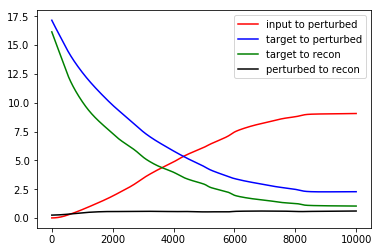

In [19]:
plt.figure()
plt.plot(np.arange(num_steps), input_adv_mses, label='input to perturbed', color='r')
plt.plot(np.arange(num_steps), target_adv_mses, label='target to perturbed', color='b')
plt.plot(np.arange(num_steps), target_recon_mses, label='target to recon', color='g')
plt.plot(np.arange(num_steps), adv_recon_mses, label='perturbed to recon', color='k')
plt.legend()
# input_recon_mses

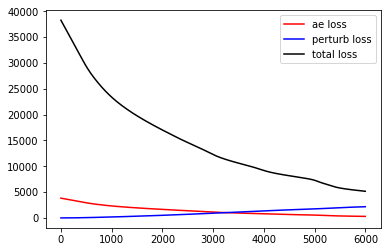

In [13]:
plt.figure()
plt.plot(np.arange(num_steps), ae_loss, label='ae loss', color='r')
plt.plot(np.arange(num_steps), perturb_loss, label='perturb loss', color='b')
plt.plot(np.arange(num_steps), total_loss, label='total loss', color='k')
plt.legend()

In [14]:
#     # DEBUG
#     ae_inp_recon, ae_targ_recon = sess.run([analyzer.model.forward_pass(input_ph), analyzer.model.forward_pass(target_ph)], feed_dict=new_feed_dict)
#     a_in_val = sess.run(analyzer.model.a, feed_dict=new_feed_dict)
#     inp_recon_loss = sess.run(analyzer.model.compute_recon_loss(a_in_val), feed_dict=new_feed_dict)
    
# fig, axes = plt.subplots(1,4, figsize=(15, 6))
# axes[0].imshow(input_image.reshape(int(np.sqrt(analyzer.model_params.num_pixels)),int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys_r")
# axes[0].set_title("input image")
# axes[1].imshow(ae_inp_recon.reshape(int(np.sqrt(analyzer.model_params.num_pixels)),int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys_r")
# axes[1].set_title("input recon")
# axes[2].imshow(target_image.reshape(int(np.sqrt(analyzer.model_params.num_pixels)),int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys_r")
# axes[2].set_title("target image")
# axes[3].imshow(ae_targ_recon.reshape(int(np.sqrt(analyzer.model_params.num_pixels)),int(np.sqrt(analyzer.model_params.num_pixels))), cmap="Greys_r")
# axes[3].set_title("target recon")

# # tf.reduce_mean(0.5 * tf.reduce_sum(tf.square(tf.subtract(self.compute_recon_from_encoding(a_in), self.x)), axis=reduc_dim), name="recon_loss")
# print('RECON LOSS', 0.5 * np.sum((input_image - ae_inp_recon)**2))
# print('RECON LOSS', 0.5 * np.sum((target_image - ae_targ_recon)**2))
# print('ae fxn recon loss', inp_recon_loss)

In [15]:
print(perturb.min(), perturb.max())
print(input_image.min(), input_image.max())
print(new_img.min(), new_img.max())
print(target_image.min(), target_image.max())

print()
print(ae_loss[-1])

-4.7599416 5.1728616
-7.6257114 8.39351
-4.387627 6.0824814
-5.9959073 5.0870733

[298.78107]
